In [13]:
import os
import time
from os.path import basename, join

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# data and model paths
test_data = '../test'
model_path = '../weights/full_densenet121_AutoWtdCE_2020-12-15_11-35_epoch49.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
label = {0: 'No DR', 1: 'Mild ', 2: 'Moderate', 3: 'Severe', 5: 'Proliferative DR'}

In [14]:
def _resize(image):
    h,w,c = image.shape
    min_dim = min(h, w)
    img_t = image[:, int(w/2-min_dim/2):int(w/2+min_dim/2)]
    img_t = cv2.resize(img_t, (300, 300))
    return img_t


def _histogram_equalization(image):
    cla = image.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
    for i in range(2):
        cla[:, :, i] = clahe.apply(image[:, :, i])
    return cla 

In [49]:
def test(model, path):
    
    result = {}
    since = time.time()

    print('-' * 10)

    model.eval()   # Set model to evaluate mode
    img = cv2.imread(path)
    image_t = _resize(img)
    image_t = _histogram_equalization(image_t)
    
    image_t = (image_t/255.0).astype(np.float32)
#     import pdb;pdb.set_trace()
    image_t = torch.from_numpy(np.array([image_t.transpose(2, 0, 1)]))
#     image_t = torch.tensor(np.array([image_t]))

    images = image_t.to(device)

    # run predictions
    with torch.set_grad_enabled(False):
        outputs = model(images)
        preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        idx = int(preds[0].cpu())
        score = float(torch.max(torch.softmax(outputs, dim=1), dim=1).values[0].cpu())
    print('prediction: ', label[idx])
    print('score: ', score)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

----------
prediction:  Mild 
score:  0.5044404864311218


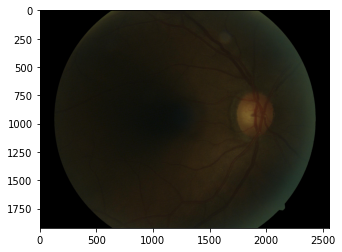

In [50]:
model = torch.load(model_path)
model = model.to(device)
test(model, join(test_data, '12649_right.jpeg'))

In [60]:
from torchinfo  import summary
from densenet import densenet121
import torchvision.models as models
import torch
import torch.nn as nn
model_ft = densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 5)
model_ft = model_ft.to(device)
summary(model_ft, input_size=(1, 3,300,300))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 1024, 9, 9]           --
|    └─Conv2d: 2-1                       [1, 64, 150, 150]         9,408
|    └─BatchNorm2d: 2-2                  [1, 64, 150, 150]         128
|    └─ReLU: 2-3                         [1, 64, 150, 150]         --
|    └─MaxPool2d: 2-4                    [1, 64, 75, 75]           --
|    └─_DenseBlock: 2-5                  [1, 256, 75, 75]          --
|    |    └─_DenseLayer: 3-1             [1, 32, 75, 75]           45,440
|    |    └─_DenseLayer: 3-2             [1, 32, 75, 75]           49,600
|    |    └─_DenseLayer: 3-3             [1, 32, 75, 75]           53,760
|    |    └─_DenseLayer: 3-4             [1, 32, 75, 75]           57,920
|    |    └─_DenseLayer: 3-5             [1, 32, 75, 75]           62,080
|    |    └─_DenseLayer: 3-6             [1, 32, 75, 75]           66,240
|    └─_Transition: 2-6                  [1, 128, 37, 37]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 1024, 9, 9]           --
|    └─Conv2d: 2-1                       [1, 64, 150, 150]         9,408
|    └─BatchNorm2d: 2-2                  [1, 64, 150, 150]         128
|    └─ReLU: 2-3                         [1, 64, 150, 150]         --
|    └─MaxPool2d: 2-4                    [1, 64, 75, 75]           --
|    └─_DenseBlock: 2-5                  [1, 256, 75, 75]          --
|    |    └─_DenseLayer: 3-1             [1, 32, 75, 75]           45,440
|    |    └─_DenseLayer: 3-2             [1, 32, 75, 75]           49,600
|    |    └─_DenseLayer: 3-3             [1, 32, 75, 75]           53,760
|    |    └─_DenseLayer: 3-4             [1, 32, 75, 75]           57,920
|    |    └─_DenseLayer: 3-5             [1, 32, 75, 75]           62,080
|    |    └─_DenseLayer: 3-6             [1, 32, 75, 75]           66,240
|    └─_Transition: 2-6                  [1, 128, 37, 37]

In [56]:
!pip install torchinfo

You should consider upgrading via the 'd:\code\thesisms\eye_diabetic\code\venv\scripts\python.exe -m pip install --upgrade pip' command.
